In [125]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import obspy
from obspy.core.utcdatetime import UTCDateTime as UTC
import random
import datetime
import scipy
from scipy.optimize import minimize
from scipy import linalg
from scipy.special import factorial as fac
from confidence import get_CI
from geopy.distance import geodesic

import emcee
import corner 

font = {'family':'sans-serif','sans-serif':['Helvetica'],
        'weight' : 'normal',
        'size'   : 24}
matplotlib.rc('font', **font)

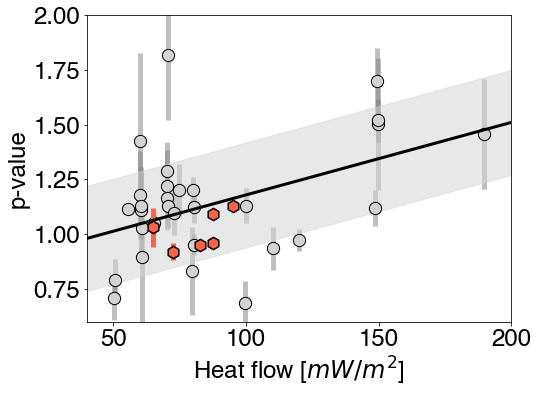

In [151]:
heat = pd.read_csv('kisslinger_heatflow_p.csv', header=None)
c    = heat.to_numpy()
x    = c[:,0]
y    = c[:,1]
yerr = c[:,2]

heat = pd.read_csv('new_heatflow_p.csv', header=None)
c    = heat.to_numpy()
xn   = c[:,0]
yn   = c[:,1]
yerrn= c[:,2]

plt.figure(figsize=[8,6])
plt.scatter(x,y, ec='k', fc='lightgrey', s=150, label='past studies')
plt.errorbar(x,y, yerr=yerr, ls='none', lw=5, color='grey', alpha=0.5, zorder=0)
plt.scatter(xn,yn, ec='k', fc='tomato', marker='h', s=150, lw=1.5, label='past studies', zorder=3)
plt.errorbar(xn,yn, yerr=yerrn, ls='none', lw=5, color='tomato', alpha=1)
plt.plot([40, 200], [0.98, 1.51], lw=3, c='k')
plt.fill_between([40, 200], np.array([0.98, 1.51])+0.24, np.array([0.98, 1.51])-0.24, color='lightgrey', alpha=0.5, zorder=0)
plt.xlim(40,200)
plt.ylim(0.6, 2)
plt.xlabel(r'Heat flow [$mW/m^2$]')
plt.ylabel('p-value')
plt.tight_layout()
plt.savefig('heatflow.png', dpi=200)

In [84]:
np.array([0.98, 1.51])+0.24

array([ 1.22,  1.75])

In [4]:
## Read catalog using pandas dataframe and convert to numpy array
def read_cat(filename):
    pdcat = pd.read_csv(filename, dtype='str')
    c    = pdcat.to_numpy()
    time = c[:,0]
    lat  = c[:,1].astype('float')
    lon  = c[:,2].astype('float')
    dep  = c[:,3].astype('float')
    mag  = c[:,4].astype('float')
    evid = c[:,11]
    obdt = []
    pydt = []
    relt = []
    for i in range(len(time)):
        obdt.append(UTC(time[i]))
        pydt.append(UTC(time[i]).datetime)
        relt.append((UTC(time[i]) - UTC(time[0])) / 86400)
    return (evid, obdt, pydt, relt, lat, lon, dep, mag)


def read_cat_hauk(filename):
    c = np.genfromtxt(filename, dtype='str')
    yr = c[:,0].astype('int')
    mo = c[:,1].astype('int')
    dy = c[:,2].astype('int')
    hr = c[:,3].astype('int')
    mi = c[:,4].astype('int')
    sc = c[:,5].astype('float')
    evid = c[:,6].astype('str')
    lon  = c[:,7].astype('float')
    lat  = c[:,8].astype('float')
    dep  = c[:,9].astype('float')
    mag  = c[:,10].astype('float')
    obdt = []
    pydt = []
    relt = []
    for i in range(len(evid)):
        tstr = '%02d%02d%02d%02d%02d%5.2f' % (yr[i],mo[i],dy[i],hr[i],mi[i],sc[i])
        obdt.append(UTC(tstr))
        pydt.append(UTC(tstr).datetime)
        relt.append((UTC(tstr) - obdt[0]) / 86400)
    return (evid, obdt, pydt, relt, lat, lon, dep, mag)


def read_cat_sep(filename):
    c = np.genfromtxt(filename, dtype='str')
    yr = c[:,0].astype('int')
    mo = c[:,1].astype('int')
    dy = c[:,2].astype('int')
    hr = c[:,3].astype('int')
    mi = c[:,4].astype('int')
    sc = c[:,5].astype('float') 
    lat  = c[:,6].astype('float')
    lon  = c[:,7].astype('float')
    dep  = c[:,8].astype('float')
    mag  = c[:,9].astype('float')
    evid = c[:,14]
    obdt = []
    pydt = []
    relt = []
    for i in range(len(evid)):
        tstr = '%02d%02d%02d%02d%02d%5.2f' % (yr[i],mo[i],dy[i],hr[i],mi[i],sc[i])
        obdt.append(UTC(tstr))
        pydt.append(UTC(tstr).datetime)
        relt.append((UTC(tstr) - obdt[0]) / 86400)
    return (evid, obdt, pydt, relt, lat, lon, dep, mag)


def read_cat_savesep(filename):
    pdcat = pd.read_csv(filename, dtype='str', sep=" |/|:|,", engine="python")
    c     = pdcat.to_numpy()
    np.savetxt('test.out', c, fmt='%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s')


# MAXC method of determining magnitude of completeness
def maxc_Mc(mag_arr, plot='no', title=''):
    bin_size = 0.05
    fc = 'lightskyblue'
    ec = 'k'
    k, bin_edges = np.histogram(mag_arr,np.arange(-1,10,bin_size))
    centers      = bin_edges[:-1] + np.diff(bin_edges)[0]/2
    correction   = 0.20
    Mc = centers[np.argmax(k)] + correction
    xloc  = 0.50
    yloc1 = 0.90
    yloc2 = 0.70
    yloc3 = 0.55

    if plot == 'yes':
        fig ,ax = plt.subplots(figsize=[18,5], ncols=2)
        ax[0].bar(bin_edges[:-1], k, width=bin_size, fc=fc, ec=ec)
        ax[0].axvline(x=Mc, c='k', ls='--', lw=3)
        ax[0].set_xlim(-0.5,4)
        ax[0].text(xloc, yloc1, 'Mc = {:.3f}'.format(Mc), transform=ax[0].transAxes)
        ax[0].text(xloc, yloc2, r'N($M \geq Mc$) = {:d}'.format(len(mag_arr[mag_arr>=Mc])), transform=ax[0].transAxes)
        ax[0].text(xloc, yloc3, r'N($M < Mc$) = {:d}'.format(len(mag_arr[mag_arr<Mc])), transform=ax[0].transAxes)        
        ax[0].set_xlabel('Magnitude')
        ax[0].set_ylabel('# events')
        ax[0].text(0.35, 1.03, title, fontsize=22, transform=ax[0].transAxes)                

        ax[1].bar(bin_edges[:-1], 100*(1-np.cumsum(k)/np.cumsum(k)[-1]), width=bin_size, fc=fc, ec=ec)
        ax[1].axvline(x=Mc, c='k', ls='--', lw=3)
        ax[1].set_xlim(-0.5,4)
        ax[1].text(xloc, yloc1, 'Mc = {:.3f}'.format(Mc), transform=ax[1].transAxes)
        ax[1].text(xloc, yloc2, r'N($M \geq Mc$) = {:d}'.format(len(mag_arr[mag_arr>=Mc])), transform=ax[1].transAxes)
        ax[1].text(xloc, yloc3, r'N($M < Mc$) = {:d}'.format(len(mag_arr[mag_arr<Mc])), transform=ax[1].transAxes)          
        ax[1].set_xlabel('Magnitude')
        ax[1].set_ylabel('Cumulaive % events')
        ax[1].text(0.35, 1.03, title, fontsize=22, transform=ax[1].transAxes)        
        plt.show()
        
    elif plot == 'no':
        pass
    
    else:
        print('Plot keyword is either "yes" or "no"')
    
    return Mc  


def epoch_Mc(mag, obspyDT, Nt=10, plot='no', title=''):
    Ndt = (obspyDT[-1]-obspyDT[0])/Nt

    epochs = []
    for i in range(int(Nt)):
        epochs.append(np.where(np.array(obspyDT)>=obspyDT[0]+Ndt*i)[0][0])

    Mcs = []
    for i in range(Nt):
        if i==Nt-1:
            sub_mag = mag[epochs[i]:-1]
        else:
            sub_mag = mag[epochs[i]:epochs[i+1]]
        Mcs.append(maxc_Mc(sub_mag, plot=plot, title=title)) 
    return epochs, Ndt, Mcs


def omorilaw(x, params):
    c, K, p = params
    return K/((x+c)**p)


def omori_syn(c, p, tmin, tmax, N):
    """
    Adapted from tgeobel's GitHub: https://github.com/tgoebel/aftershocks
    Felzer et al. 2002, Triggering of 1999 Mw 7.1 Hector Mine earthquake
    - define create power-law distributed aftershock time vector between tmin and tmax
    - tmin can be = 0, Omori-K parameter is a fct. of all four parameter (tmax-tmin), p, and N
    INPUT:  c, p       - omori parameters describing time shift for complete recording and rate decay exponent
                       - in alphabetical order  
           tmin, tmax  - time window for aftershock catalog
           N           - total number of aftershocks
    """
    vRand = np.random.random_sample( N)
    #===========================================================================
    #          case1:  p != 1
    #===========================================================================    
    #if p != 1.0: #abs(p - 1) < 1e-6:
    p += 1e-4 # this will make it unlikely for p to be exactly 1
    a1 = (tmax + c)**(1-p)
    a2 = (tmin + c)**(1-p)
    a3 = vRand*a1 + (1-vRand)*a2#     
    otimes = a3**(1/(1-p))-c
#     else: # p == 1
#         a1 = np.log( tmax + c)
#         a2 = np.log( tmin + c)
#         a3 = vRand*a1 + (1-vRand)*a2
#         otimes = np.exp( a3) - c
    otimes.sort()
    return otimes


def ogata_logL(otimes, params):
    c, K, p = params
    S, T = min(otimes), max(otimes)
    n = len(otimes)
    if abs(p - 1) < 1e-8:
        A = np.log(T+c) - np.log(S+c)
    else:
        A = ((T+c)**(1-p) - (S+c)**(1-p))/(1-p)
    L = -n*np.log(K) + p*np.sum(np.log(otimes+c)) + K*A
    return L


def hol_logL(otimes, params):
    c, p = params
    S, T = min(otimes), max(otimes)
    n = len(otimes)
    if abs(p - 1) < 1e-8:
        D = (1/c) / (np.log(1+T/c) - np.log(1+S/c))
    else:
        D = ((1-p)/c) / ((1+T/c)**(1-p) - (1+S/c)**(1-p))
    L = -n*np.log(D) + p*np.sum(np.log(1+otimes/c))
    return L



def hol_post(otimes, params):
    c, p = params
    S, T = min(otimes), max(otimes)
    n = len(otimes)
    if abs(p - 1) < 1e-8:
        D = (1/c) / (np.log(1+T/c) - np.log(1+S/c))
    else:
        D = ((1-p)/c) / ((1+T/c)**(1-p) - (1+S/c)**(1-p))
    prob = np.prod(D/((1+otimes/c)**p)) * 1/c * 1/p
    return prob



def hol_getK(otimes, params):
    c, p = params
    S, T = min(otimes), max(otimes)
    n = len(otimes)
    if abs(p - 1) < 1e-8:
        D = (1/c) / (np.log(1+T/c) - np.log(1+S/c))
    else:
        D = ((1-p)/c) / ((1+T/c)**(1-p) - (1+S/c)**(1-p))
    L = -n*np.log(D) + p*np.sum(np.log(1+otimes/c))
    K = D * n * c**p
    return L, K

 Mainshock magnitude: 5.97 
 Mainshock time: 2004-09-28T17:15:24.260000Z 
 Minimum magnitude: 1.50 
 Maximum radius: 18.73 
 Start time: 1980-01-01T00:00:00.000000Z 
 End time: 2021-01-01T00:00:00.000000Z 
 # events selected: 855 



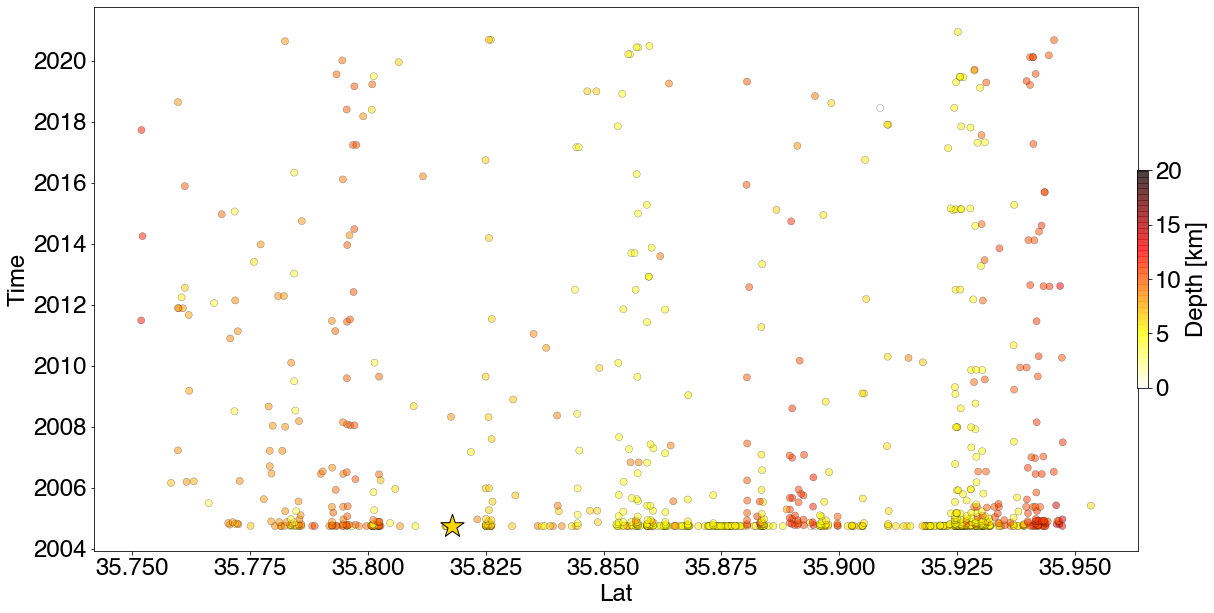

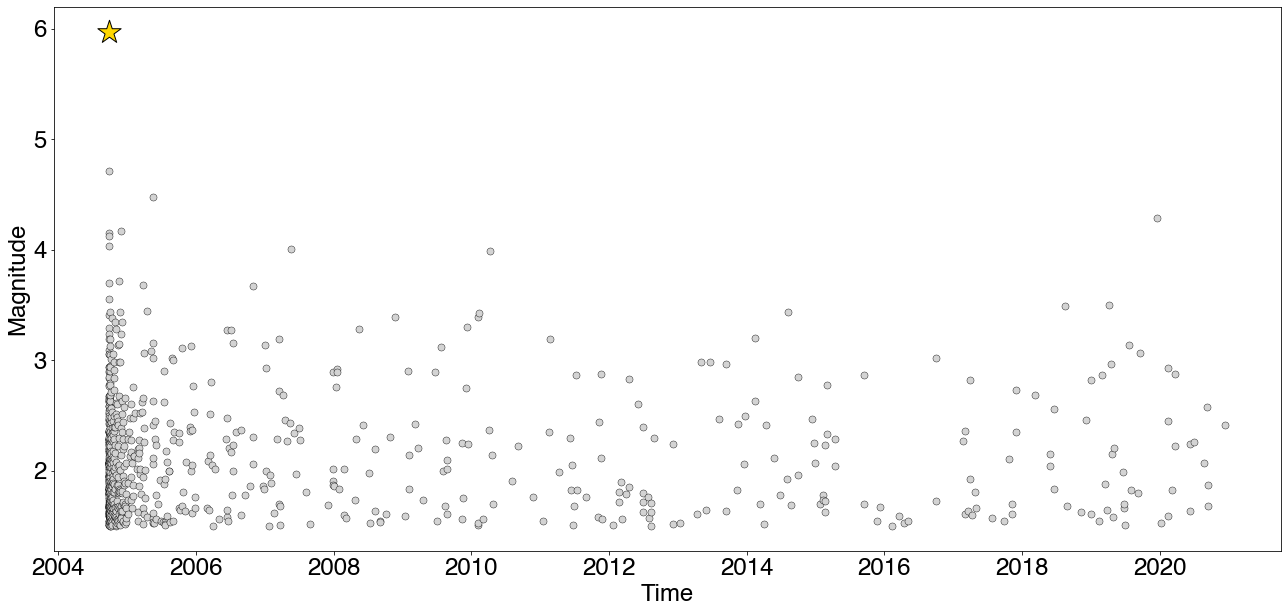

In [5]:
# Read catalog
#cat = read_cat('west_cat.txt')
#cat = read_cat('east_cat.txt')
cat = read_cat('PKcat.txt')
#cat = read_cat('LPcat.txt')
#cat = read_cat_hauk('events.hauk')
#cat = read_cat_sep('prague.txt')
evid, obdt, pydt, relt, lat, lon, dep, mag = np.array(cat)

# covered time period
t_start = UTC('19800101')
t_termi = UTC('20210101')


# MS info
ms_id = np.argmax(mag[obdt >= t_start])
ms = {'id':evid[ms_id], 'obdt':obdt[ms_id], 'pydt':pydt[ms_id], 'tAMS':relt[ms_id], 
      'lat':lat[ms_id], 'lon':lon[ms_id], 'dep':dep[ms_id], 'mag':mag[ms_id]}

# save meta parameters
meta = {'t_start'   : t_start,
        't_termi'   : t_termi,
        'Mcut'      : 1.5,
        'rmax'      : 10**(0.25*ms['mag']-.22),  # max radius of influence (Gardner & Knopoff, 1967)
        'nbin'      : 100, 
        'c_bound'   : [1e-4,   2],
        'K_bound'   : [   2, 1e3],
        'p_bound'   : [  .2,  2],
        'c0'        : .5, 
        'K0'        : 50, 
        'p0'        : 1.1,
        'ylim'      : [1e-3, 1e5],
        'xlim'      : [1e-3, 1e3],
        'syn_c'     : 0.6,
        'syn_p'     : 1.3,
        'syn_tStart': 1e-2,
        'syn_tEnd'  : 1e3, 
        'syn_N'     : 4000,}


# get aftershocks within a radius
aR = []
for i in range(len(evid)):
    aR.append(geodesic((ms['lat'], ms['lon']),(lat[i], lon[i])).km)
aR = np.array(aR)
rd_id = aR <= meta['rmax']


# selections
mc_id  = mag  >= meta['Mcut']
as_id  = obdt >  ms['obdt']
end_id = obdt <  t_termi
rd_id  = aR   <= meta['rmax']
select = mc_id * as_id * end_id * rd_id
evid, obdt, pydt, relt, lat, lon, dep, mag = np.array(cat).T[select].T

print(' Mainshock magnitude: %.2f \n' % ms['mag'],
      'Mainshock time: %s \n'         % ms['obdt'],
      'Minimum magnitude: %.2f \n'    % meta['Mcut'],
      'Maximum radius: %.2f \n'       % meta['rmax'], 
      'Start time: %s \n'             % meta['t_start'],
      'End time: %s \n'               % meta['t_termi'],      
      '# events selected: %d \n'      % select.sum())


relt = relt.astype('float')
lat = lat.astype('float')
lon = lon.astype('float')
dep = dep.astype('float')
mag = mag.astype('float')
relt = relt - ms['tAMS']


plt.figure(figsize=[22,10])
sc = plt.scatter(lat, pydt, s=50, c=dep, cmap='hot_r', vmin=0, vmax=20, ec='k', lw=0.4, alpha=0.5)
plt.scatter(ms['lat'], ms['pydt'], s=600, ec='k', fc='gold', marker='*')
plt.xlabel('Lat')
plt.ylabel('Time')
plt.colorbar(sc, label='Depth [km]', shrink=0.4, pad=-0.001)
plt.show()

plt.figure(figsize=[22,10])
sc = plt.scatter(pydt, mag, s=50, fc='lightgrey', ec='k', lw=0.4)
plt.scatter(ms['pydt'], ms['mag'], s=600, ec='k', fc='gold', marker='*')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.show()

In [6]:
# Choose dataset: 
data = '1'

if data == '0':
    # Synthetic dataset
    c = meta['syn_c']
    p = meta['syn_p']
    synt = omori_syn(c, p, meta['syn_tStart'], meta['syn_tEnd'], meta['syn_N'])
    otimes = np.array(sorted(synt))

elif data == '1':
    # Real dataset
    otimes = np.array(sorted(relt))



# Calc likelihood:
o_objFunc = lambda X: ogata_logL(otimes, X)
h_objFunc = lambda X: hol_logL(otimes, X)

disp = 0
method = 'SLSQP'


# Ogata 1989: MLE
o_Bounds  = np.array([meta['c_bound'], meta['K_bound'], meta['p_bound']])
o_Par0    = np.array([meta['c0'], meta['K0'], meta['p0']])
ogata_fit = scipy.optimize.minimize(o_objFunc, o_Par0, bounds=o_Bounds, tol = 1e-4, method=method, options={'disp': disp, 'maxiter':500})
print(ogata_fit)

# Holschneider et al., 2012: Bayesian
h_Bounds   = np.array([meta['c_bound'], meta['p_bound']])
h_Par0     = np.array([meta['c0'], meta['p0']])
holsch_fit = scipy.optimize.minimize(h_objFunc, h_Par0, bounds=h_Bounds, tol = 1e-4, method=method, options={'disp': disp, 'maxiter':500})
finalL, K  = hol_getK(otimes, holsch_fit['x'])
print('\n',holsch_fit)
print('       K:',K)


meta['Ogata_fit'] = list(ogata_fit['x'])
meta['Bayes_fit'] = [holsch_fit['x'][0], K, holsch_fit['x'][1]]

meta

     fun: 204.66813230613423
     jac: array([-0.03221893, -0.00462341,  1.51185608])
 message: 'Optimization terminated successfully'
    nfev: 100
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([  1.46470826e-02,   5.17005638e+01,   9.10600122e-01])

      fun: 5121.8599207503439
     jac: array([-1.11791992, -0.2388916 ])
 message: 'Optimization terminated successfully'
    nfev: 39
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 0.01460717,  0.91052912])
       K: 51.6837814304


/Users/ykliu/Applications/miniconda3/envs/seismo/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


{'t_start': 1980-01-01T00:00:00.000000Z,
 't_termi': 2021-01-01T00:00:00.000000Z,
 'Mcut': 1.5,
 'rmax': 18.728370830175486,
 'nbin': 100,
 'c_bound': [0.0001, 2],
 'K_bound': [2, 1000.0],
 'p_bound': [0.2, 2],
 'c0': 0.5,
 'K0': 50,
 'p0': 1.1,
 'ylim': [0.001, 100000.0],
 'xlim': [0.001, 1000.0],
 'syn_c': 0.6,
 'syn_p': 1.3,
 'syn_tStart': 0.01,
 'syn_tEnd': 1000.0,
 'syn_N': 4000,
 'Ogata_fit': [0.014647082555102222, 51.700563809432083, 0.91060012194251427],
 'Bayes_fit': [0.014607172517191749, 51.683781430409574, 0.91052911537941816]}

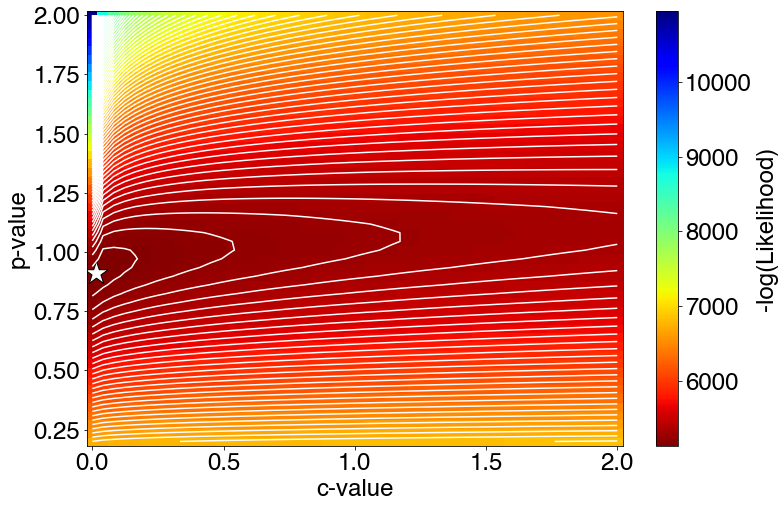

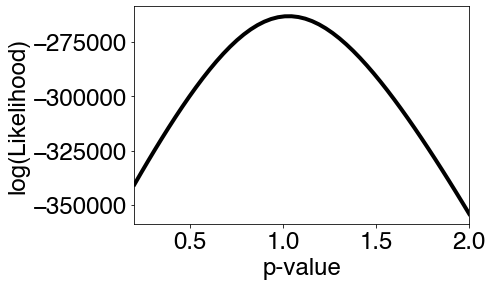

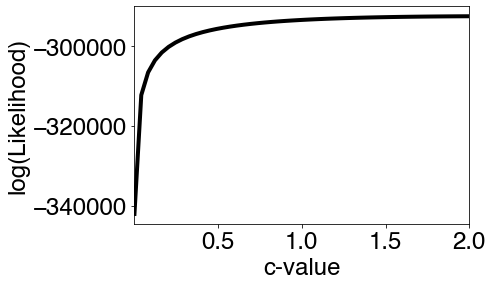

In [7]:
Cs = np.linspace(meta['c_bound'][0], meta['c_bound'][1])
Ps = np.linspace(meta['p_bound'][0], meta['p_bound'][1])

L = np.zeros([len(Cs), len(Ps)])
for i in range(len(Cs)):
    for j in range(len(Ps)):
        L[i,j] = h_objFunc((Cs[i],Ps[j]))
L = L.T
        
plt.figure(figsize=[12,8])
im = plt.pcolormesh(Cs, Ps, L, cmap='jet_r', shading='auto')
plt.colorbar(im, label='-log(Likelihood)')
plt.contour(Cs, Ps, L, levels=100, colors='w')
plt.scatter(meta['Bayes_fit'][0], meta['Bayes_fit'][2], marker='*', s=600, ec='k', fc='w')
#plt.xscale('log')
plt.xlabel('c-value')
plt.ylabel('p-value')
plt.show()        


plt.figure()
plt.plot(Ps, -np.sum(L,1), lw=4, c='k')
plt.xlabel('p-value')
plt.ylabel('log(Likelihood)')
plt.xlim(min(Ps), max(Ps))
plt.show()

plt.figure()
plt.plot(Cs, -np.sum(L,0), lw=4, c='k')
plt.xlabel('c-value')
plt.ylabel('log(Likelihood)')
plt.xlim(min(Cs), max(Cs))
plt.show()

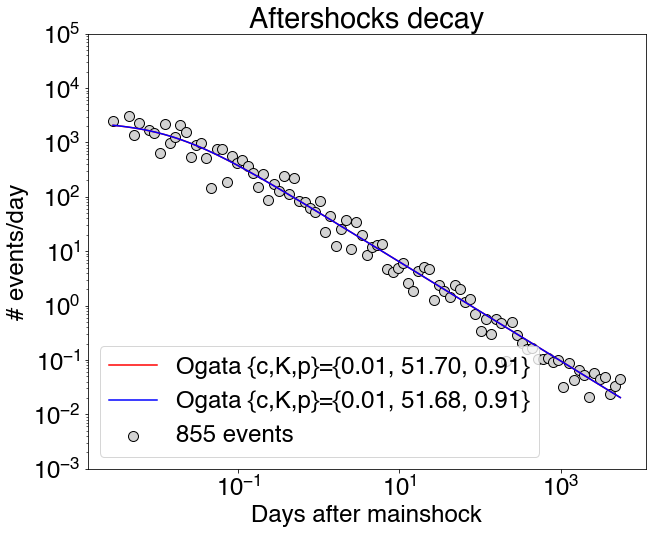

In [8]:
plot_res = 'both'

bins = np.logspace(np.log10(otimes[0]), np.log10(otimes[-1]), meta['nbin'])
count, bine = np.histogram(otimes, bins=bins)
bin_loc = (bine[1:] + bine[:-1]) / 2
occ_dens = count/np.diff(bins)


plt.figure(figsize=[10,8])
plt.scatter(bin_loc, occ_dens, s=100, ec='k', fc='lightgrey', label='%d events' % len(otimes))
plt.xscale('log')
plt.yscale('log')
plt.ylim(meta['ylim'])
#plt.xlim(meta['xlim'])
plt.xlabel('Days after mainshock')
plt.ylabel('# events/day')

lgdstr = 'Ogata {c,K,p}={%.2f, %.2f, %.2f}'
if plot_res=='o':
    plt.plot(bin_loc, omorilaw(bin_loc, meta['Ogata_fit']), c='r', label=lgdstr % tuple(meta['Ogata_fit']))
elif plot_res=='h': 
    plt.plot(bin_loc, omorilaw(bin_loc, meta['Bayes_fit']), c='b', label=lgdstr % tuple(meta['Bayes_fit']))
elif plot_res=='both':
    plt.plot(bin_loc, omorilaw(bin_loc, meta['Ogata_fit']), c='r', label=lgdstr % tuple(meta['Ogata_fit']))
    plt.plot(bin_loc, omorilaw(bin_loc, meta['Bayes_fit']), c='b', label=lgdstr % tuple(meta['Bayes_fit']))

plt.legend(loc='lower left')
plt.title('Aftershocks decay')
plt.show()    

## MCMC ensemble sampler

In [9]:
#%% Now try to fit with MCMC!
def log_prior(theta):
    c, K, p = theta
    c1 ,c2 = meta['c_bound']
    K1 ,K2 = meta['K_bound']    
    p1 ,p2 = meta['p_bound']
    if c1 < c < c2 and K1 < K < K2 and p1 < p < p2:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - o_objFunc(theta)

In [10]:
##initialize walkers in gaussian ball around minimized result 
pos = meta['Ogata_fit'] + 1e-3 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 5000, progress=True);



100%|██████████| 5000/5000 [00:18<00:00, 266.36it/s]


[ 42.76440951  38.55668856  38.72544688]


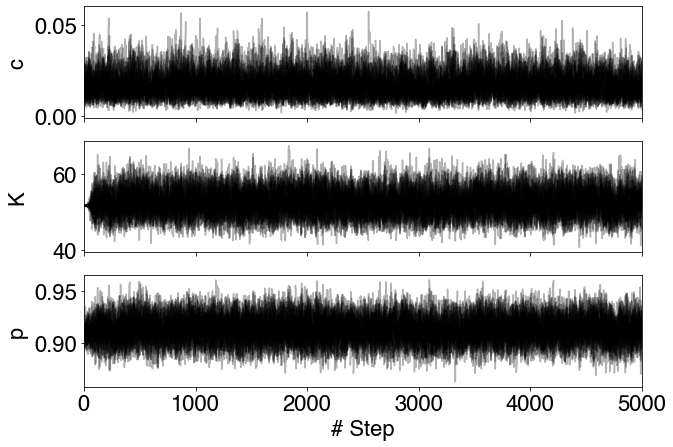

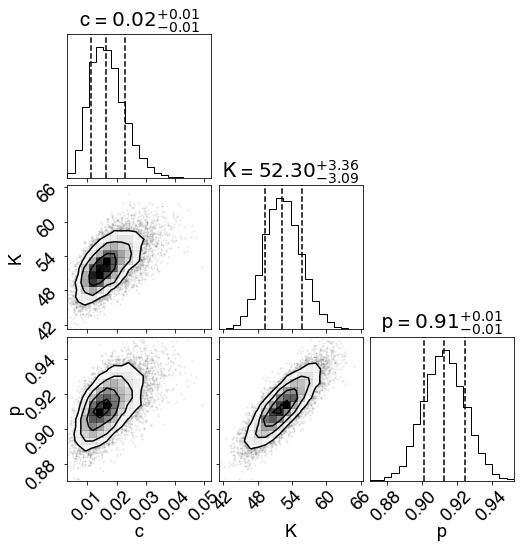

In [47]:
# Check out the chains
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ['c', 'K', 'p']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel('# Step')

# check autocorrelation time and corner plot
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

matplotlib.rcParams.update({'font.size': 18})
fig = corner.corner(flat_samples, labels=labels, 
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 20})
matplotlib.rcParams.update({'font.size': 22})

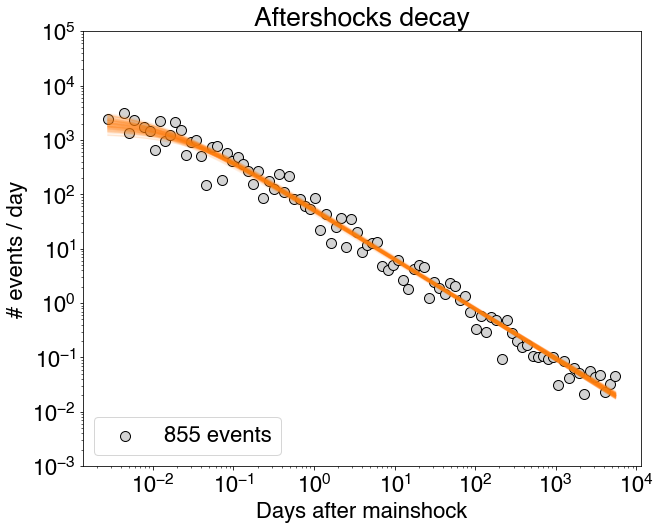

In [32]:
plt.figure(figsize=[10,8])
plt.scatter(bin_loc, occ_dens, s=100, ec='k', fc='lightgrey', label='%d events' % len(otimes))
plt.xscale('log')
plt.yscale('log')
plt.ylim(meta['ylim'])
#plt.xlim(meta['xlim'])
plt.xlabel('Days after mainshock')
plt.ylabel('# events / day')

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(bin_loc, omorilaw(bin_loc, sample), 'C1', alpha=0.1)
plt.legend(loc='lower left')
plt.title('Aftershocks decay')
plt.show() 